In [1]:
import sys
sys.path.append('../scripts/')
from robot import * 
from scipy.stats import multivariate_normal

In [2]:
class Particle:
    def __init__(self,init_pose):
        self.pose = init_pose
        
    def motion_update(self,nu,omega,time,noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        # 式(5.12)処理
        noised_nu = nu + ns[0] * math.sqrt(abs(nu) / time) + ns[1] * math.sqrt(abs(omega) / time)
        noised_omega = omega + ns[2] * math.sqrt(abs(nu) / time) + ns[3] * math.sqrt(abs(omega) / time)
        self.pose = IdealRobot.state_transition(noised_nu,noised_omega,time,self.pose) # 粒子の移動
        

In [3]:
# 現在地と粒子の数

class Mcl:
    # motion_nosise_stds:標準偏差σ_ab
    def __init__(self,init_pose,num,motion_noise_stds):
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2,v["no"]**2,v["on"]**2,v["oo"]**2 ]) # 与えられた要素を二乗して対角行列へ返す
        self.motion_noise_rate_pdf = multivariate_normal(cov = c)
        
    def motion_update(self,nu,omega,time):
        #print(self.motion_noise_rate_pdf.cov)
        # class Particl のmotion_updateを全粒子に行う
        for p in self.particles: p.motion_update(nu,omega,time,self.motion_noise_rate_pdf)
    
    # 粒子を描画する(位置、姿勢)
    def draw(self,ax,elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] # ベクトルのx成分
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs,ys,vxs,vys,color = "blue" , alpha = 0.5)) # 粒子の位置と姿勢を登録

In [4]:
class EstimationAgent(Agent):
    def __init__(self,time_interval,nu,omega,estimator):
        super().__init__(nu,omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self,observation = None):
        self.estimator.motion_update(self.prev_nu,self.prev_omega,self.time_interval)# class Mclのmotion_update
        self.prev_nu,self.prev_omega = self.nu,self.omega
        return self.nu,self.omega

    def draw(self,ax,elems):
        self.estimator.draw(ax,elems)
        elems.append(ax.text(0,0,"hoge",fontsize = 10))

In [5]:
initial_pose = np.array([0,0,0]).T
estimator = Mcl(initial_pose,100,motion_noise_stds = {"nn":0.01,"no":0.02,"on":0.03,"oo":0.04})
a = EstimationAgent(0.1,0.2,10.0 / 180 * math.pi,0.1)
estimator.motion_update(0.2,10.0 / 180 * math.pi,0.1)
for p in estimator.particles:
    print(p.pose)


[0.02804466 0.00014039 0.01001192]
[1.62503899e-02 5.37119126e-05 6.61051423e-03]
[0.02075406 0.00011279 0.01086863]
[0.01550236 0.00013127 0.01693539]
[0.01592697 0.00013057 0.01639564]
[0.02127405 0.00011896 0.01118323]
[0.02165151 0.00017057 0.01575535]
[0.025104   0.00038344 0.0305456 ]
[0.02298908 0.0001574  0.01369294]
[0.01843049 0.00016305 0.01769336]
[0.02304077 0.00012344 0.01071513]
[0.01886189 0.00019646 0.02083108]
[1.22871670e-02 7.36324893e-05 1.19851236e-02]
[0.02395394 0.00013435 0.01121707]
[0.02112037 0.00022274 0.02109159]
[0.01789046 0.00015032 0.01680459]
[0.02101329 0.00014921 0.01420136]
[0.02318028 0.00011598 0.01000699]
[0.01829147 0.00015027 0.01643045]
[0.0187317  0.00023836 0.02544826]
[0.01603903 0.00017117 0.02134381]
[1.98948782e-02 4.16112368e-05 4.18310438e-03]
[0.02512207 0.00017776 0.01415144]
[0.02456985 0.00012422 0.01011181]
[0.02107829 0.00011926 0.01131614]
[0.01680078 0.00011554 0.01375339]
[0.02267981 0.00027106 0.0239022 ]
[0.01961254 0.00023

<IPython.core.display.Javascript object>


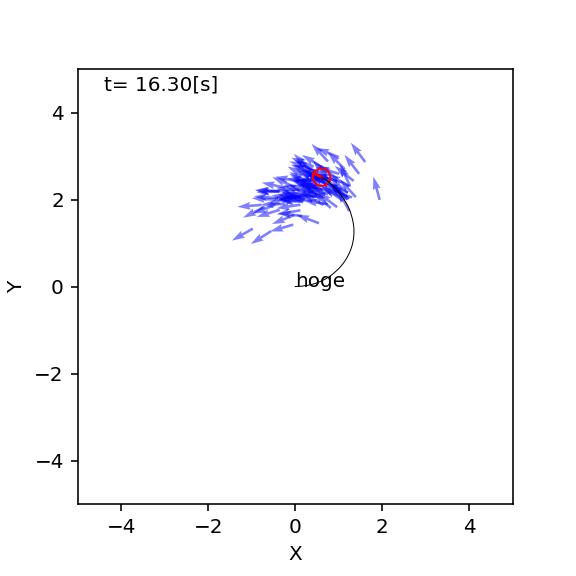

In [7]:
def trial(motion_noise_stds):
    time_interval = 0.1
    world = World(30,time_interval)
    
    initial_pose = np.array([0,0,0]).T
    estimator = Mcl(initial_pose,100,motion_noise_stds)
    circling = EstimationAgent(time_interval,0.2,10.0 / 180 * math.pi,estimator)
    r = Robot(initial_pose,sensor = None,agent = circling,color = "red")
    world.append(r)
    
    world.draw()
    
trial({"nn":0.19,"no":0.001,"on":0.13,"oo":0.2})
# noiseのパラメタがテキトーなので、robotと粒子が乖離してしまう